<a href="https://colab.research.google.com/github/spctr01/av/blob/main/AV_job_thon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install lightgbm
!pip install catboost
!pip install xgboost

In [59]:
import pandas as pd 
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold , GroupKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate, cross_val_score

from lightgbm import LGBMClassifier
import xgboost as xg
import catboost as cb


### change dir

In [3]:
cd /content/drive/MyDrive/Colab Notebooks/competetion/jobthon

/content/drive/MyDrive/Colab Notebooks/competetion/jobthon


# Read data

In [35]:
train_data = pd.read_csv('train_Df64byy.csv')
test_data = pd.read_csv('test_YCcRUnU.csv')
train_data.drop(['ID'], axis=1, inplace= True)
test_data.drop(['ID'], axis=1, inplace= True)



# **EDA**

In [37]:

train_data.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [38]:
#train_data['City_Code'].unique() = 36
#train_data['Accomodation_Type'].unique() = 2

# train_data['Reco_Insurance_Type'].unique() = 2
#train_data['Is_Spouse'].unique() = 2
#train_data['Health Indicator'].unique() = 10
#train_data['Holding_Policy_Duration'].unique() = 15

#train_data['Holding_Policy_Type'].unique() = 5
#train_data['Reco_Policy_Cat'].unique() = 22



#### Balance of data

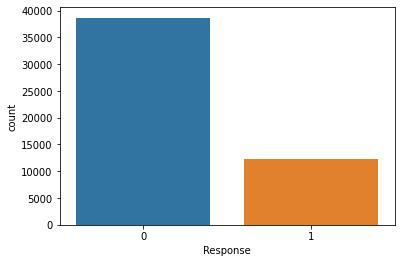

In [39]:
sns.countplot(train_data['Response'])

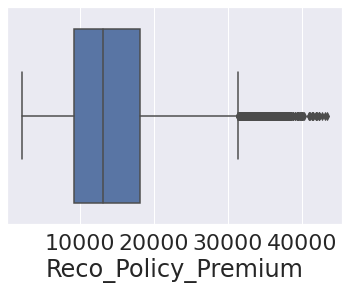

In [58]:
sns.boxplot(x=train_data['Reco_Policy_Premium'])

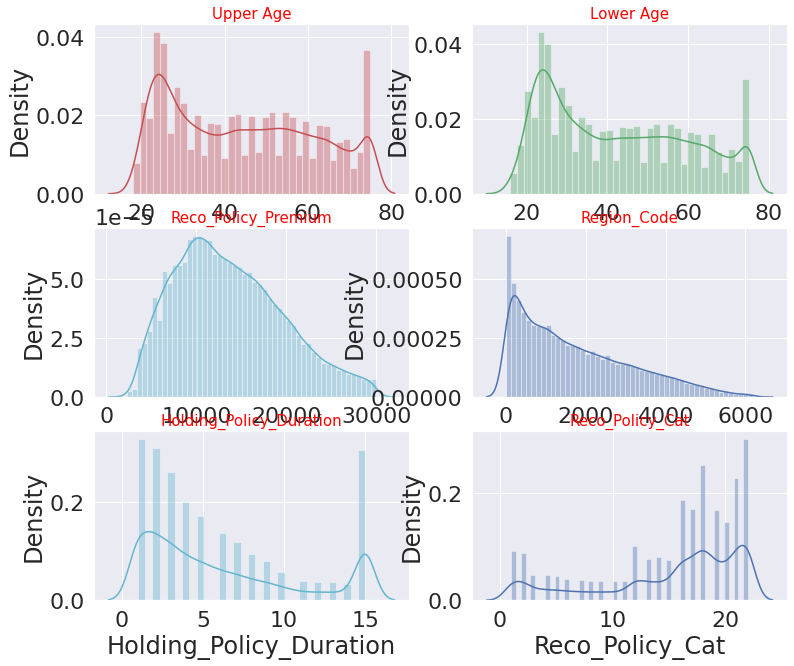

In [91]:
fig, ax = plt.subplots(3,2, figsize =(11,8))
plt.subplots_adjust(bottom=0, right=1, top=1)

ax[0,0].set_title('Upper Age', color='red', fontsize = 15)
sns.distplot(train_data['Upper_Age'],  color="r", ax=ax[0,0])

ax[0,1].set_title('Lower Age', color='red', fontsize = 15)
sns.distplot(train_data['Lower_Age'],  color="g", ax=ax[0,1])

ax[1,0].set_title('Reco_Policy_Premium', color='red', fontsize = 15)
sns.distplot(train_data['Reco_Policy_Premium'],  color="c", ax=ax[1,0])

ax[1,1].set_title('Region_Code', color='red', fontsize = 15)
sns.distplot(train_data['Region_Code'],  color="b", ax=ax[1,1])

ax[2,0].set_title('Holding_Policy_Duration', color='red', fontsize = 15)
sns.distplot(train_data['Holding_Policy_Duration'],  color="c", ax=ax[2,0])

ax[2,1].set_title('Reco_Policy_Cat', color='red', fontsize = 15)
sns.distplot(train_data['Reco_Policy_Cat'],  color="b", ax=ax[2,1])

plt.show()

#### pandas profiling

In [40]:
profile = pp.ProfileReport(train_data, title='Pandas Profiling Report', explorative=True)
profile.to_file("profile.html")



Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_notebook_iframe()

# Preprocessing

In [71]:
# print(train_data.shape)
# train_data = train_data.dropna(axis=0)
# print(train_data.shape)

In [72]:
train_data.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,1,0,36,36,0,X1,15.0,3.0,22,11628.0,0
2,C5,3732,0,0,32,32,0,none,1.0,1.0,19,7450.0,1
3,C24,4378,0,1,52,48,0,X1,15.0,3.0,19,17780.0,0
4,C8,2190,1,0,44,44,0,X2,3.0,1.0,16,10404.0,0
5,C9,1785,1,0,52,52,0,X2,5.0,1.0,22,15264.0,1


In [93]:
#remove outlier as seen in boxplot values above 30000
print(train_data.shape)
print(train_data.Reco_Policy_Premium.max())
d = train_data[train_data.Reco_Policy_Premium < 30000]
train_data = d
print(train_data.shape)

(49651, 13)
29991.0
(49651, 13)


In [73]:
#train data
train_data['Holding_Policy_Duration'] = train_data['Holding_Policy_Duration'].replace('14+', '15.0')
train_data['Holding_Policy_Duration'] = train_data['Holding_Policy_Duration'].astype(float)
print(train_data['Holding_Policy_Duration'].unique())

#test data
test_data['Holding_Policy_Duration'] = test_data['Holding_Policy_Duration'].replace('14+', '15.0')
test_data['Holding_Policy_Duration'] = test_data['Holding_Policy_Duration'].astype(float)


[15.  1.  3.  5. nan  9. 14.  7.  2. 11. 10.  8.  6.  4. 13. 12.]


In [74]:
#train data
train_data['Health Indicator'] = train_data['Health Indicator'].replace(np.nan, 'none')
print(train_data['Health Indicator'].unique())

#test data
test_data['Health Indicator'] = train_data['Health Indicator'].replace(np.nan, 'none')


['X1' 'none' 'X2' 'X4' 'X3' 'X6' 'X5' 'X8' 'X7' 'X9']


In [75]:
enc = preprocessing.LabelEncoder()
hot_enc = preprocessing.OneHotEncoder()

cols = ['Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse']
hot_cols = ['City_Code', 'Health Indicator', ]

#train data
train_data[cols] = train_data[cols].apply(enc.fit_transform)
df = pd.get_dummies(train_data, columns =hot_cols)

#test_data
test_data[cols] = test_data[cols].apply(enc.fit_transform)
test_df = pd.get_dummies(test_data, columns =hot_cols)

df.head()


,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Health Indicator_X1,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Health Indicator_none
0,3213,1,0,36,36,0,15.0,3.0,22,11628.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3732,0,0,32,32,0,1.0,1.0,19,7450.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4378,0,1,52,48,0,15.0,3.0,19,17780.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2190,1,0,44,44,0,3.0,1.0,16,10404.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
5,1785,1,0,52,52,0,5.0,1.0,22,15264.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


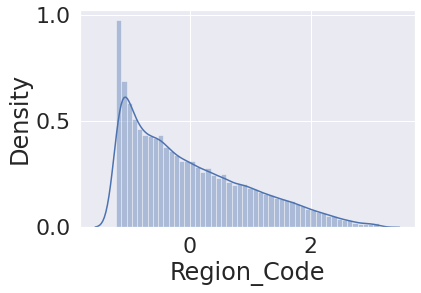

In [96]:
sns.distplot(df['Region_Code'])


In [97]:
xx = np.log[df['Region_Code']]
sns.distplot(xx['Region_Code'])


TypeError: ignored

In [76]:
#scale the data
ss = StandardScaler()
scale = ['Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type','Reco_Policy_Cat', 'Region_Code','Upper_Age','Lower_Age']

#train
train_features= ss.fit_transform(df[scale])
df[scale]= train_features


#test
test_features= ss.fit_transform(test_df[scale])
test_df[scale]= test_features

# ***EXp(test)***

In [ ]:
df1 = df.drop(['Lower_Age'], axis=1)
test_df = test_df.drop(['Lower_Age'], axis=1)
#df1['average'] = df[['Upper_Age', 'Lower_Age']].mean(axis=1)
#df1 = df.drop(['Lower_Age'], axis=1)
#df1 = df.drop(['Upper_Age'], axis=1)


df = df1
df.head()


,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Health Indicator_X1,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Health Indicator_none
0,3213,1,0,36,0,15.0,3.0,22,11628.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1117,0,1,75,0,NaN,NaN,22,30510.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3732,0,0,32,0,1.0,1.0,19,7450.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4378,0,1,52,0,15.0,3.0,19,17780.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2190,1,0,44,0,3.0,1.0,16,10404.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
'''
cat boost =0.7624203821656051
[0.76415674 0.76391107 0.76391107 0.75617246 0.75297875]

lgbm
[0.76255988 0.76108586 0.76698194 0.75506695 0.7521189 ]
without
 0.7605384690969834
[[7693   45]
 [2392   47]]

drop lower age

0.7571976024368674
[[7662   24]
 [2447   44]]

drop uper age

0.7555271691068095
[[7652   22]
 [2466   37]]

adding aberage of lower and uper age
0.7586715141986833
[[7670   25]
 [2431   51]]

xgb


'''

'\ncat boost =0.7624203821656051\n\nwithout\n 0.7605384690969834\n[[7693   45]\n [2392   47]]\n\ndrop lower age\n\n0.7571976024368674\n[[7662   24]\n [2447   44]]\n\ndrop uper age\n\n0.7555271691068095\n[[7652   22]\n [2466   37]]\n\nadding aberage of lower and uper age\n0.7586715141986833\n[[7670   25]\n [2431   51]]\n\n'

# **Train test split**


In [77]:
x = df.drop('Response',axis = 1)
y = df['Response']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)


print('training data \n',y_train.value_counts())
print('test data \n',y_test.value_counts())

training data 
 0    30164
1     9556
Name: Response, dtype: int64
test data 
 0    7578
1    2353
Name: Response, dtype: int64


In [78]:
y_train.value_counts()
print(30904/9801)

3.1531476379961227


# Model Buildung and Predicting


In [ ]:
sk = StratifiedKFold(n_splits=4)
ssk = StratifiedShuffleSplit(n_splits=4)

# scoring = {'acc': 'accuracy',
#            'prec_macro': 'precision_macro',
#            'rec_micro': 'recall_macro'}


#models
xgb = xg.XGBClassifier()
lgb = LGBMClassifier()
cat = cb.CatBoostClassifier()


# xgb_score= cross_val_score(xgb, x_train, y_train, scoring='f1', cv=sk,n_jobs=-1).mean()
# lgb_score= cross_val_score(lgb, x_train, y_train, scoring='f1', cv=sk, n_jobs=-1).mean()
# cat_score= cross_val_score(cat, x_train, y_train, scoring='f1', cv=sk, n_jobs=-1).mean()
# print(xgb_score,'\n', lgb_score,'\n', cat_score)


# b_xgb_score= cross_val_score(xgb, x_train, y_train, scoring='f1', cv=ssk, n_jobs=-1).mean()
# b_lgb_score= cross_val_score(lgb, x_train, y_train, scoring='f1', cv=ssk, n_jobs=-1).mean()
# b_cat_score= cross_val_score(cat, x_train, y_train, scoring='f1', cv=ssk, n_jobs=-1).mean()
# print(b_xgb_score,'\n', b_lgb_score,'\n', b_cat_score)



**xgb**

0.7630651495317692
[[7578    0]
 [2353    0]]


Text(20.5, 0.5, 'Predicted')

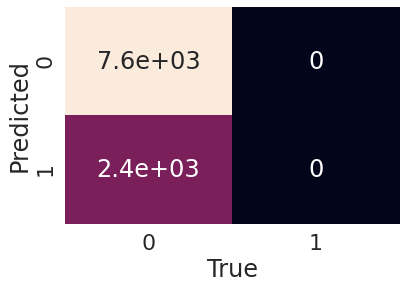

In [79]:
xgb = xg.XGBClassifier()

xgb.fit(x_train,y_train)
print(xgb.score(x_test, y_test))

pred = xgb.predict(x_test)
conf_mat = confusion_matrix(y_test, pred)
print (conf_mat)


#visualise confusion matrix with seaborn heat map
sns.set(font_scale = 2)
sns.heatmap(conf_mat, annot = True, cbar= False)
plt.xlabel('True')
plt.ylabel('Predicted')

**lgbm**

0.7652804350015104
[[7540   38]
 [2293   60]]


Text(20.5, 0.5, 'Predicted')

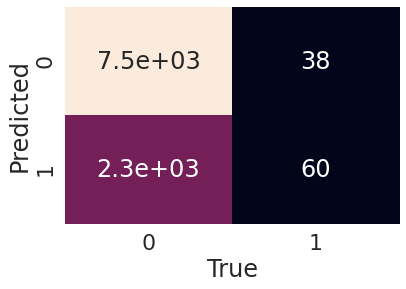

In [80]:
lgb = LGBMClassifier()

lgb.fit(x_train,y_train)
print(lgb.score(x_test, y_test))

pred = lgb.predict(x_test)
conf_mat = confusion_matrix(y_test, pred)
print (conf_mat)


#visualise confusion matrix with seaborn heat map
sns.set(font_scale = 2)
sns.heatmap(conf_mat, annot = True, cbar= False)
plt.xlabel('True')
plt.ylabel('Predicted')

**catboost**

Learning rate set to 0.049626
0:	learn: 0.6775515	total: 21.1ms	remaining: 21.1s
1:	learn: 0.6630969	total: 41.2ms	remaining: 20.6s
2:	learn: 0.6501280	total: 62.3ms	remaining: 20.7s
3:	learn: 0.6386199	total: 81.5ms	remaining: 20.3s
4:	learn: 0.6284389	total: 100ms	remaining: 20s
5:	learn: 0.6176833	total: 119ms	remaining: 19.7s
6:	learn: 0.6096990	total: 141ms	remaining: 20.1s
7:	learn: 0.6025136	total: 161ms	remaining: 19.9s
8:	learn: 0.5961128	total: 183ms	remaining: 20.2s
9:	learn: 0.5903634	total: 202ms	remaining: 20s
10:	learn: 0.5849774	total: 222ms	remaining: 20s
11:	learn: 0.5806738	total: 243ms	remaining: 20s
12:	learn: 0.5768783	total: 264ms	remaining: 20s
13:	learn: 0.5731449	total: 285ms	remaining: 20.1s
14:	learn: 0.5695711	total: 304ms	remaining: 20s
15:	learn: 0.5662424	total: 324ms	remaining: 20s
16:	learn: 0.5633926	total: 343ms	remaining: 19.8s
17:	learn: 0.5599716	total: 367ms	remaining: 20s
18:	learn: 0.5577966	total: 395ms	remaining: 20.4s
19:	learn: 0.5558571	to

Text(20.5, 0.5, 'Predicted')

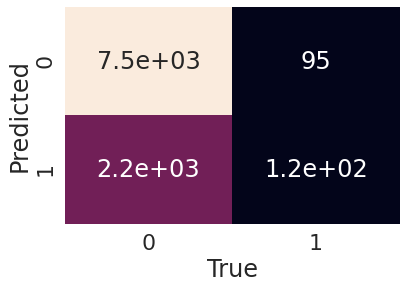

In [81]:
cat = cb.CatBoostClassifier()

cat.fit(x_train,y_train)
print(cat.score(x_test, y_test))

pred = cat.predict(x_test)
conf_mat = confusion_matrix(y_test, pred)
print (conf_mat)


#visualise confusion matrix with seaborn heat map
sns.set(font_scale = 2)
sns.heatmap(conf_mat, annot = True, cbar= False)
plt.xlabel('True')
plt.ylabel('Predicted')

In [ ]:
pred = model.predict(test_df)
s = pd.read_csv('sample_submission_QrCyCoT.csv')
s['Response'] = pred
s.to_csv('sample_cat.csv', index = False)
s.head()



,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0
